## Imports

In [1]:
import heapq
import math
import time
from collections import defaultdict
from collections import namedtuple
from contextlib import contextmanager
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

## Common code

In [2]:
@contextmanager
def elapsed_time(title):
    start = time.time()
    yield
    elapsed = time.time() - start
    print '%s: %.2f secs' % (title, elapsed)


def get_xy(ratings_df):
    y = ratings_df['rating']
    x = ratings_df.drop('rating', axis=1)
    return x, y


def root_mean_squared_error(y, y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))


def show_scores_plot(k_neighbors_values, val_scores, train_scores, model_name):
    _, ax = plt.subplots(1, 1, figsize=(15, 10))

    ax.plot(k_neighbors_values, val_scores, label='validation')
    ax.plot(k_neighbors_values, train_scores, label='train')

    ax.set_xlabel('k_neighbors')
    ax.set_ylabel('$R^2$')
    ax.set_title('Test and validation scores for different k_neighbors values (%s)' % model_name)

    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


def score_model(ratings_df, model_f, model_name):
    train_val_ratings_df, test_ratings_df = train_test_split(ratings_df)

    train_ratings_df, validation_ratings_df = train_test_split(train_val_ratings_df)

    best_score = -float('inf')
    best_k_neighbors = None

    model = model_f()

    model = model.fit(train_ratings_df)

    k_neighbors_values = [1, 5, 10, 20, 30, 40, 50, 60, 80, 100]

    val_scores = []
    train_scores = []

    for k_neighbors in k_neighbors_values:
        model.set_k_neighbors(k_neighbors=k_neighbors)

        x_train, y_train = get_xy(train_ratings_df)
        x_val, y_val = get_xy(validation_ratings_df)

        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)

        train_score = r2_score(y_train, y_train_pred)
        val_score = r2_score(y_val, y_val_pred)

        if val_score > best_score:
            best_score = val_score
            best_k_neighbors = k_neighbors

        val_scores.append(val_score)
        train_scores.append(train_score)

        print 'k: %d, validation score: %.5f, train score: %.5f\n' % (k_neighbors, val_score, train_score)

    print 'best k: %d, best score: %.5f' % (best_k_neighbors, best_score)

    model = model_f(k_neighbors=best_k_neighbors)

    model = model.fit(train_val_ratings_df)

    x_train_val, y_train_val = get_xy(train_val_ratings_df)
    x_test, y_test = get_xy(test_ratings_df)

    y_train_val_pred = model.predict(x_train_val)
    y_test_pred = model.predict(x_test)

    train_val_score = r2_score(y_train_val, y_train_val_pred)
    test_score = r2_score(y_test, y_test_pred)

    train_val_rmse = root_mean_squared_error(y_train_val, y_train_val_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)

    print 'train score: %.4f, test score: %.4f' % (train_val_score, test_score)
    print 'train rmse: %.4f, test rmse: %.4f' % (train_val_rmse, test_rmse)

    show_scores_plot(k_neighbors_values, val_scores, train_scores, model_name=model_name)

## Read Ratings

In [3]:
def date_parse(time_in_secs):
    return datetime.utcfromtimestamp(float(time_in_secs))


def read_ratings_df_with_timestamp(file_name):
    with elapsed_time('loaded csv'):
        ratings_df = pd.read_csv(file_name, parse_dates=['timestamp'], date_parser=date_parse)
    return ratings_df

## Baseline Models

In [4]:
class BaselineModel(object):
    def predict_rating(self, user_id, movie_id):
        pass

    def predict(self, x):
        return [self.predict_rating(row['userId'], row['movieId']) for _, row in x.iterrows()]

    def score(self, x, y):
        return r2_score(y, self.predict(x))

    
class BaselineMeansModel(BaselineModel):
    def __init__(self, user_weight=0.5):
        self.user_weight = user_weight
        self.mean_user_ratings = None
        self.mean_movie_ratings = None

    def fit(self, ratings_df):
        self.mean_user_ratings = ratings_df.groupby('userId')['rating'].mean()
        self.mean_movie_ratings = ratings_df.groupby('movieId')['rating'].mean()
        return self

    def predict_rating(self, user_id, movie_id):
        user_rating = self.mean_user_ratings[user_id]
        movie_rating = self.mean_movie_ratings.get(movie_id, user_rating)
        return self.user_weight * user_rating + (1.0 - self.user_weight) * movie_rating


class BaselineEffectsModel(BaselineModel):
    def __init__(self, movie_lambda=5.0, user_lambda=20.0):
        self.movie_lambda = movie_lambda
        self.user_lambda = user_lambda

        self.y_mean = None
        self.movie_effects = None
        self.user_effects = None
        self.user_groups = None

    def calculate_movie_effect(self, ratings):
        return (ratings - self.y_mean).sum() / (self.movie_lambda + len(ratings))

    def calculate_movie_effects(self, movie_ratings):
        return movie_ratings.agg(lambda ratings: self.calculate_movie_effect(ratings))

    def calculate_user_effect(self, ratings_df):
        s = 0.0
        for _, row in ratings_df.iterrows():
            s += row['rating'] - self.y_mean - self.movie_effects[row['movieId']]

        return s / (self.user_lambda + len(ratings_df))

    def calculate_user_effects(self, user_groups):
        user_ids = []
        user_effects = []

        for user_id, group in user_groups:
            user_effect = self.calculate_user_effect(group)

            user_ids.append(user_id)
            user_effects.append(user_effect)

        return pd.Series(user_effects, index=user_ids)

    def fit(self, ratings_df):
        with elapsed_time('effects init'):
            _, y_train = get_xy(ratings_df)
            self.y_mean = y_train.mean()

            movie_ratings = ratings_df.groupby('movieId')['rating']
            self.user_groups = ratings_df.groupby('userId')

            self.movie_effects = self.calculate_movie_effects(movie_ratings)
            self.user_effects = self.calculate_user_effects(self.user_groups)

        return self

    def create_modified_ratings(self, ratings_df):
        ratings_df = ratings_df.copy()

        for index, row in ratings_df.iterrows():
            user_id = row['userId']
            movie_id = row['movieId']
            rating = row['rating']
            pred_rating = self.predict_baseline_rating(user_id, movie_id)

            residual = rating - pred_rating

            ratings_df.loc[index, 'rating'] = residual

        return ratings_df

    def predict_baseline_rating(self, user_id, movie_id):
        return self.y_mean + self.movie_effects.get(movie_id, 0.0) + self.user_effects[user_id]

    def predict_rating(self, user_id, movie_id):
        return self.predict_baseline_rating(user_id, movie_id)

## Movie Similarity Model

Movie similarity model.

First we removed all main global effects the same way we did for our baseline model.
We subtracted the total rating mean, then we removed the movie effects and then user effects.

As a result our utility matrix was the residuals after applying the baseline model. 

It allowed us to remove some scale differences in the way different users rate movies.

In our movie similarity model we predict the rating for a movie (movie_id) and a user (user_id) by

1) finding k closest neighbors (k=40,50)

For assessing item-item similarity we used a distance based on the mean squared error between items [1]:

$s_{ij}=\frac{|U(i,j)|}{\sum_{u \in U(i,j)} (r_{ui}-r_{uj})^2 + \alpha}$, where U(i,j) is the set of users who rated both items j and k.

2) since relatively large number of movies have low number of ratings (1-3), some of the movies have zero neighbors, in this case we use a baseline prediction (in 6.9-7.2% of the cases for the test set).

[1] R.Bell, Y.Koren, "Improved Neighborhood-based Collaborative Filtering", *KDD-Cup and Workshop*, ACM press, 2007

loaded csv: 0.13 secs
effects init: 5.33 secs
fit: 80.71 secs
used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 1, validation score: -0.17962, train score: 0.65851

used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 5, validation score: 0.21904, train score: 0.75852

used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 10, validation score: 0.26488, train score: 0.73967

used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 20, validation score: 0.28137, train score: 0.70002

used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 30, validation score: 0.28604, train score: 0.67076

used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 40, validation score: 0.28700, train score: 0.64859

used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 50, validation score: 0.28680, train score: 0.63046

used baseline predictions: 4.9%
used baseline predictions: 9.1%
k: 60, validation score: 0.28625, t

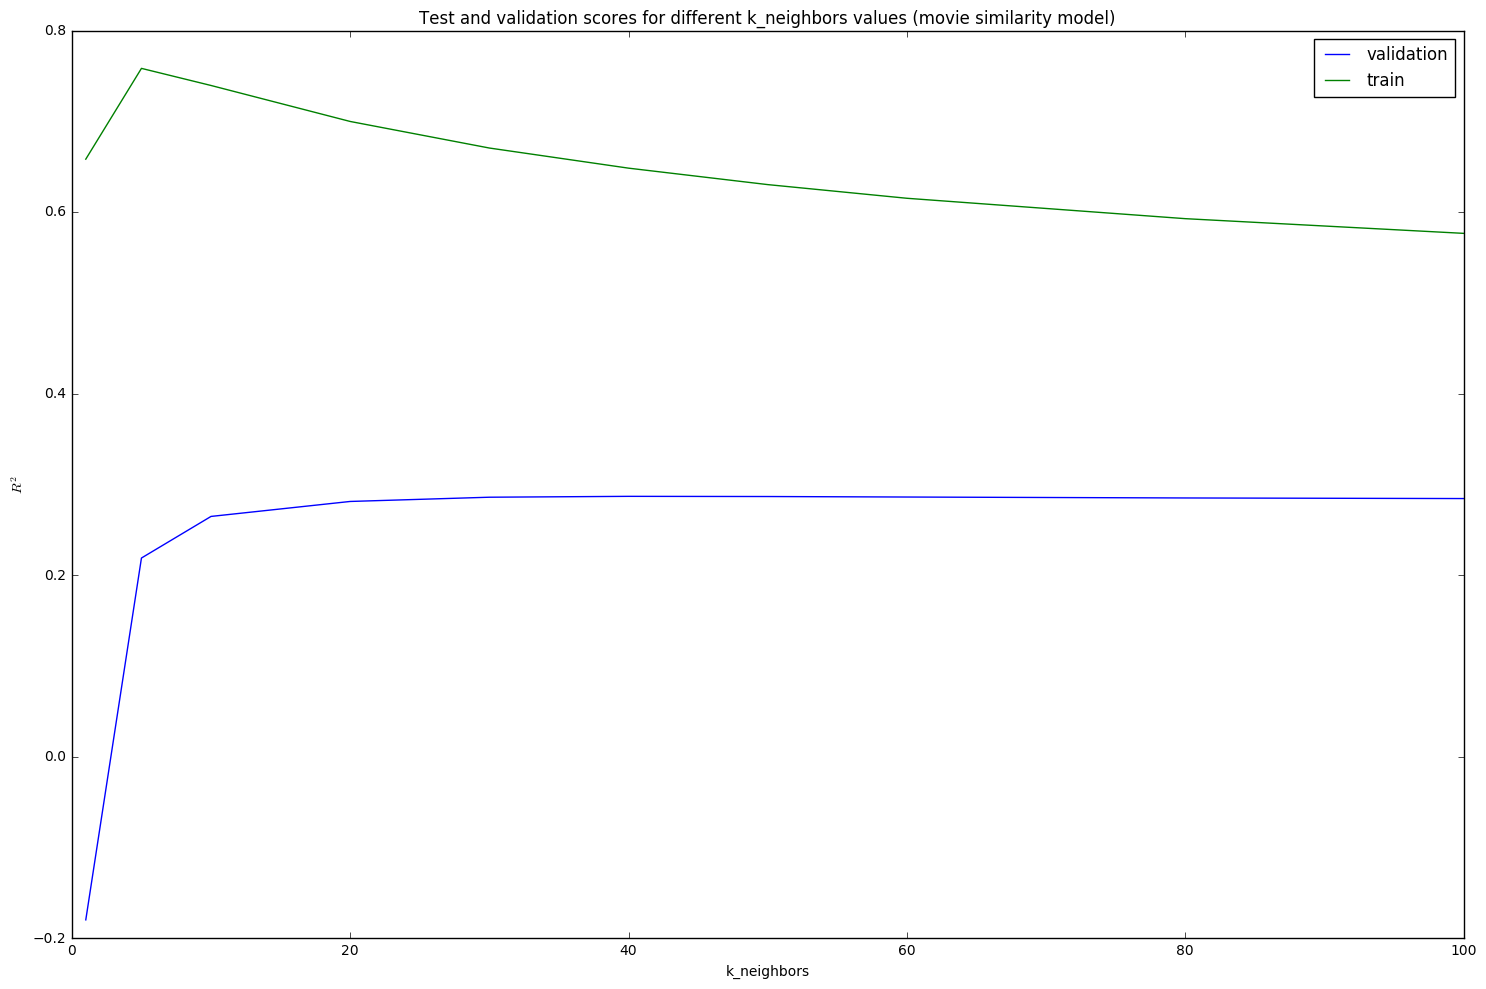

score model: 688.62 secs


In [5]:
MovieSimilarity = namedtuple('MovieSimilarity', ['movie_id', 'similarity'])


class MovieSimilarityModel(BaselineModel):
    def __init__(self, k_neighbors=40):
        self.k_neighbors = k_neighbors

        self.baseline_model = BaselineEffectsModel()
        self.ratings_by_movie = defaultdict(dict)
        self.ratings_by_user = defaultdict(dict)
        self.raters_by_movie = {}
        self.movie_similarity = {}
        # self.movie_aij = {}

    def set_k_neighbors(self, k_neighbors):
        self.k_neighbors = k_neighbors

    def calculate_common_raters(self, movie_id_1, movie_id_2):
        raters1 = self.raters_by_movie[movie_id_1]
        raters2 = self.raters_by_movie[movie_id_2]
        return raters1 & raters2

    def get_common_ratings(self, movie_id, raters):
        all_ratings = self.ratings_by_movie[movie_id]
        ratings = []
        for rater_id in raters:
            ratings.append(all_ratings[rater_id])

        return np.array(ratings)

    def calculate_similarity(self, movie_id_1, movie_id_2):
        common_raters = self.calculate_common_raters(movie_id_1, movie_id_2)
        support = len(common_raters)
        if support <= 1:
            similarity = 0.0
            # aij = 0.0
        else:
            ratings1 = self.get_common_ratings(movie_id_1, common_raters)
            ratings2 = self.get_common_ratings(movie_id_2, common_raters)

            alpha = 4.0

            similarity = support / (np.power(ratings1 - ratings2, 2).sum() + alpha)

            # aij = np.multiply(ratings1, ratings2).sum() / support

        return similarity

    def fit(self, ratings_df):
        with elapsed_time('fit'):
            self.baseline_model.fit(ratings_df)

            ratings_df = self.baseline_model.create_modified_ratings(ratings_df)

            unique_movie_ids = np.array(sorted(ratings_df['movieId'].unique()))

            for _, row in ratings_df.iterrows():
                movie_id = row['movieId']
                user_id = row['userId']
                rating = row['rating']
                self.ratings_by_movie[movie_id][user_id] = rating
                self.ratings_by_user[user_id][movie_id] = rating

            for movie_id in unique_movie_ids:
                self.raters_by_movie[movie_id] = set(self.ratings_by_movie[movie_id].keys())

            for movie_index_1, movie_id_1 in enumerate(unique_movie_ids):
                for movie_index_2 in xrange(movie_index_1 + 1, len(unique_movie_ids)):
                    movie_id_2 = unique_movie_ids[movie_index_2]

                    similarity = self.calculate_similarity(movie_id_1, movie_id_2)
                    movie_pair = (movie_id_1, movie_id_2)
                    self.movie_similarity[movie_pair] = similarity
                    # self.movie_aij[movie_pair] = aij

        return self

    def get_similarity(self, movie_id_1, movie_id_2):
        if movie_id_1 < movie_id_2:
            id_1 = movie_id_1
            id_2 = movie_id_2
        else:
            id_1 = movie_id_2
            id_2 = movie_id_1

        return self.movie_similarity.get((id_1, id_2), -1.0)

    def clear_predict_caches(self):
        self.zero_prediction_count = 0

    def predict_rating(self, user_id, movie_id):
        ratings = self.ratings_by_user[user_id]

        elements = []

        for movie_id_2 in ratings:
            if movie_id != movie_id_2:
                similarity = self.get_similarity(movie_id, movie_id_2)
                if similarity > 0.0:
                    elements.append(MovieSimilarity(movie_id_2, similarity))

        movie_similarities = heapq.nlargest(self.k_neighbors, elements, key=lambda e: e.similarity)

        if len(movie_similarities) > 0:
            similarity_sum = 0.0
            product_sum = 0.0
            for movie_similarity in movie_similarities:
                movie_id_2 = movie_similarity.movie_id
                rating = ratings[movie_id_2]
                similarity = movie_similarity.similarity

                product_sum += similarity * rating
                similarity_sum += similarity

            rating = product_sum / similarity_sum
        else:
            rating = 0.0
            self.zero_prediction_count += 1

        result = self.baseline_model.predict_baseline_rating(user_id, movie_id) + rating

        return result

    def predict(self, x):
        self.clear_predict_caches()
        predictions = [self.predict_rating(row['userId'], row['movieId']) for _, row in x.iterrows()]
        print 'used baseline predictions: %.1f%%' % (100.0 * self.zero_prediction_count / len(predictions))
        return predictions

    
ratings_df = read_ratings_df_with_timestamp('ml-latest-small/ratings.csv')

with elapsed_time('score model'):
    score_model(ratings_df, model_f=MovieSimilarityModel, model_name='movie similarity model')

## User Similarity Model

effects init: 4.96 secs
fit: 46.81 secs
used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 1, validation score: -0.06681, train score: 0.30505

used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 5, validation score: 0.22058, train score: 0.43478

used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 10, validation score: 0.24519, train score: 0.41833

used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 20, validation score: 0.25206, train score: 0.39045

used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 30, validation score: 0.25255, train score: 0.37425

used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 40, validation score: 0.25160, train score: 0.36420

used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 50, validation score: 0.25120, train score: 0.35761

used baseline predictions: 4.9%
used baseline predictions: 5.3%
k: 60, validation score: 0.25069, train score: 0.35290

u

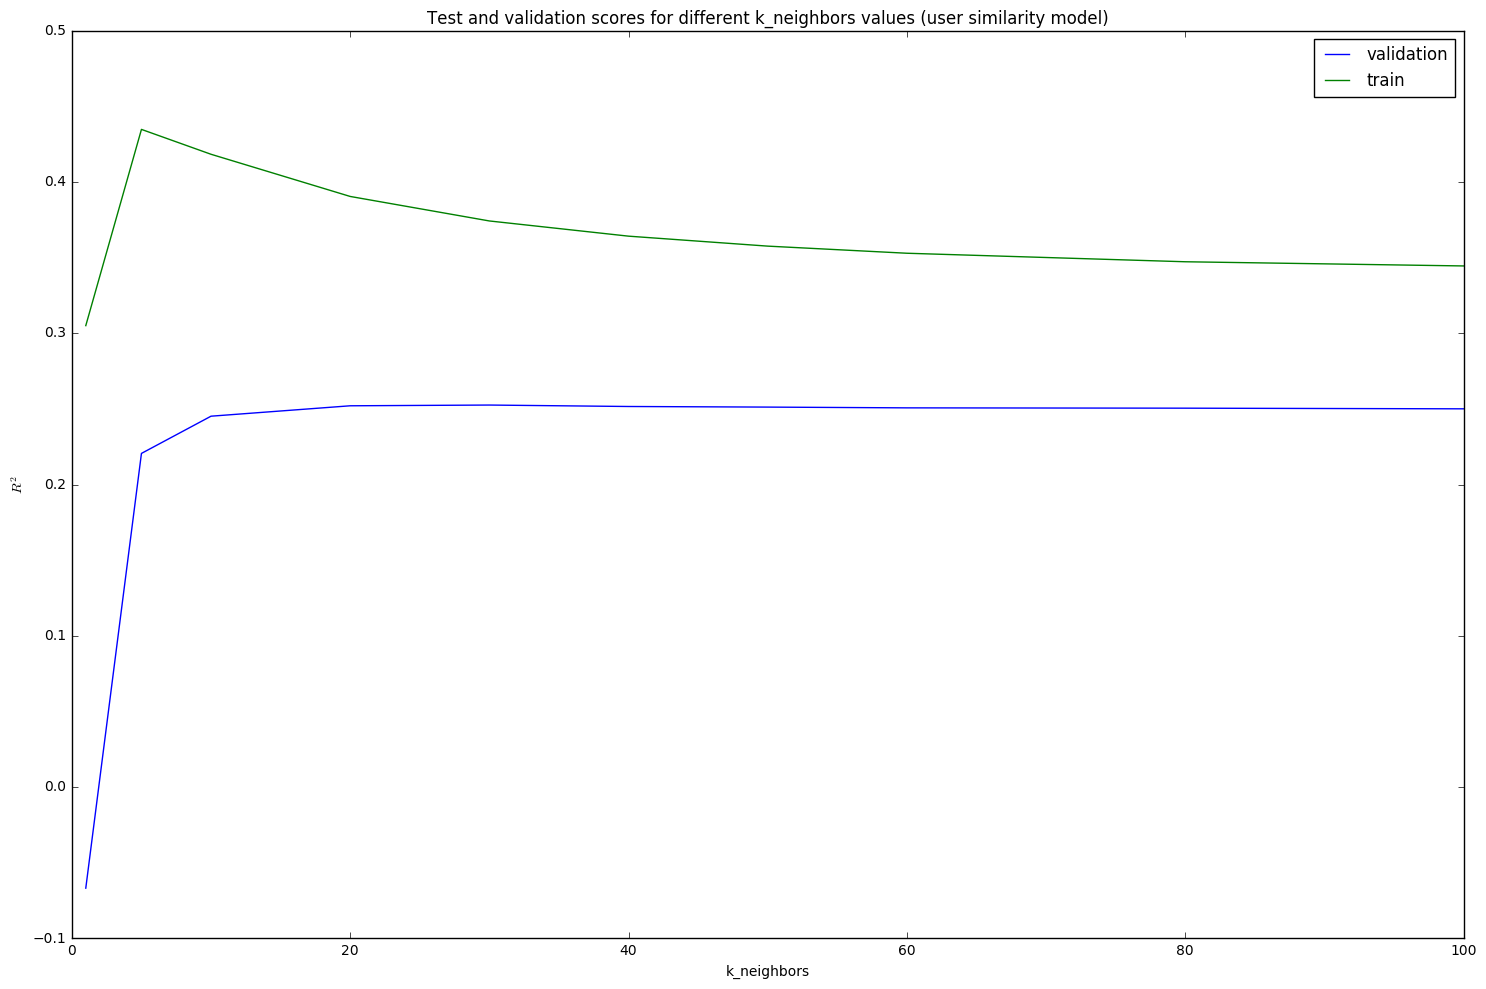

build model: 266.72 secs


In [6]:
UserSimilarity = namedtuple('UserSimilarity', ['user_id', 'similarity'])


class UserSimilarityModel(BaselineModel):
    def __init__(self, k_neighbors=40):
        self.k_neighbors = k_neighbors

        self.baseline_model = BaselineEffectsModel()
        self.ratings_by_movie = defaultdict(dict)
        self.ratings_by_user = defaultdict(dict)
        self.movies_by_user = {}
        self.user_similarity = {}

    def set_k_neighbors(self, k_neighbors):
        self.k_neighbors = k_neighbors

    def calculate_common_movies(self, user_id_1, user_id_2):
        movies1 = self.movies_by_user[user_id_1]
        movies2 = self.movies_by_user[user_id_2]
        return movies1 & movies2

    def get_common_ratings(self, user_id, movies):
        all_ratings = self.ratings_by_user[user_id]
        ratings = []
        for movie_id in movies:
            ratings.append(all_ratings[movie_id])

        return np.array(ratings)

    def calculate_similarity(self, user_id_1, user_id_2):
        common_movies = self.calculate_common_movies(user_id_1, user_id_2)
        support = len(common_movies)
        if support <= 1:
            similarity = 0.0
            # aij = 0.0
        else:
            ratings1 = self.get_common_ratings(user_id_1, common_movies)
            ratings2 = self.get_common_ratings(user_id_2, common_movies)

            alpha = 4.0

            similarity = support / (np.power(ratings1 - ratings2, 2).sum() + alpha)

        return similarity

    def fit(self, ratings_df):
        with elapsed_time('fit'):
            self.baseline_model.fit(ratings_df)

            ratings_df = self.baseline_model.create_modified_ratings(ratings_df)

            unique_user_ids = np.array(sorted(ratings_df['userId'].unique()))

            for _, row in ratings_df.iterrows():
                movie_id = row['movieId']
                user_id = row['userId']
                rating = row['rating']
                self.ratings_by_movie[movie_id][user_id] = rating
                self.ratings_by_user[user_id][movie_id] = rating

            for user_id in unique_user_ids:
                self.movies_by_user[user_id] = set(self.ratings_by_user[user_id].keys())

            for user_index_1, user_id_1 in enumerate(unique_user_ids):
                for user_index_2 in xrange(user_index_1 + 1, len(unique_user_ids)):
                    user_id_2 = unique_user_ids[user_index_2]

                    similarity = self.calculate_similarity(user_id_1, user_id_2)
                    user_pair = (user_id_1, user_id_2)
                    self.user_similarity[user_pair] = similarity

        return self

    def get_similarity(self, user_id_1, user_id_2):
        if user_id_1 < user_id_2:
            id_1 = user_id_1
            id_2 = user_id_2
        else:
            id_1 = user_id_2
            id_2 = user_id_1

        return self.user_similarity.get((id_1, id_2), -1.0)

    def clear_predict_caches(self):
        self.zero_prediction_count = 0

    def predict_rating(self, user_id, movie_id):
        ratings = self.ratings_by_movie[movie_id]

        elements = []

        for user_id_2 in ratings:
            if user_id != user_id_2:
                similarity = self.get_similarity(user_id, user_id_2)
                if similarity > 0.0:
                    elements.append(UserSimilarity(user_id_2, similarity))

        user_similarities = heapq.nlargest(self.k_neighbors, elements, key=lambda e: e.similarity)

        if len(user_similarities) > 0:
            similarity_sum = 0.0
            product_sum = 0.0
            for user_similarity in user_similarities:
                user_id_2 = user_similarity.user_id
                rating = ratings[user_id_2]
                similarity = user_similarity.similarity

                product_sum += similarity * rating
                similarity_sum += similarity

            rating = product_sum / similarity_sum
        else:
            rating = 0.0
            self.zero_prediction_count += 1

        result = self.baseline_model.predict_baseline_rating(user_id, movie_id) + rating

        return result

    def predict(self, x):
        self.clear_predict_caches()
        predictions = [self.predict_rating(row['userId'], row['movieId']) for _, row in x.iterrows()]
        print 'used baseline predictions: %.1f%%' % (100.0 * self.zero_prediction_count / len(predictions))
        return predictions

    
with elapsed_time('build model'):
    score_model(ratings_df, model_f=UserSimilarityModel, model_name='user similarity model')

## Blending Model

In [7]:
class BlendingModel(object):
    def __init__(self, models):
        self.models = models
        self.regression = LinearRegression()

    def get_blend_predictions(self, x):
        predictions = []
        for model in self.models:
            y_pred = model.predict(x)
            predictions.append(y_pred)
        pred_arr = np.array(predictions).T
        return pred_arr

    def fit(self, ratings_df):
        with elapsed_time('total fit'):
            for model in self.models:
                model.fit(ratings_df)

            x, y = get_xy(ratings_df)

            with elapsed_time('get blend predictions'):
                blend_predictions = self.get_blend_predictions(x)

            user_groups = x.groupby('userId')
            movie_groups = x.groupby('movieId')
            supports = []
            for _, row in x.iterrows():
                user_id = row['userId']
                movie_id = row['movieId']
                user_support = len(user_groups.get_group(user_id))
                movie_support = len(movie_groups.get_group(movie_id))
                support = min(user_support, movie_support)
                supports.append(support)

            # print Counter(supports)

            self.regression.fit(blend_predictions, y)

            print 'linear regression coefficients: %s, intercept: %.3f' % (
                self.regression.coef_, self.regression.intercept_)

    def predict(self, x):
        blend_predictions = self.get_blend_predictions(x)

        return self.regression.predict(blend_predictions)


ModelRecord = namedtuple('ModelRecord', ['name', 'model'])


def score_models(ratings_df, model_records):
    train_ratings_df, test_ratings_df = train_test_split(ratings_df)
    x_train, y_train = get_xy(train_ratings_df)
    x_test, y_test = get_xy(test_ratings_df)

    print

    for model_record in model_records:
        model_name, model = model_record
        model.fit(train_ratings_df)

        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        train_r2_score = r2_score(y_train, y_train_pred)
        test_r2_score = r2_score(y_test, y_test_pred)

        train_rmse = root_mean_squared_error(y_train, y_train_pred)
        test_rmse = root_mean_squared_error(y_test, y_test_pred)

        print '%s' % model_name
        print 'train r2 score: %.4f, test r2 score: %.4f' % (train_r2_score, test_r2_score)
        print 'train rmse: %.4f, test rmse: %.4f\n' % (train_rmse, test_rmse)

Here's a case where blending worked really well.

If we look at the baseline movie mean model, it gives us test $R^2$ score of 0.123-0.125.
For the baseline user mean model, we have $R^2$ = 0.170-0.174.

But their blend gives us much better result, $R^2$ = 0.254-0.259

In [8]:
def score_baseline_mean_blending_model(ratings_df):
    blend_models = [
        BaselineMeansModel(user_weight=0.0),
        BaselineMeansModel(user_weight=1.0),
    ]
    models = [
        ModelRecord('movie mean model', BaselineMeansModel(user_weight=0.0)),
        ModelRecord('user mean model', BaselineMeansModel(user_weight=1.0)),
        ModelRecord('blending model (user & movie mean models)', BlendingModel(blend_models)),
    ]
    score_models(ratings_df, models)

    
score_baseline_mean_blending_model(ratings_df)


movie mean model
train r2 score: 0.2952, test r2 score: 0.1232
train rmse: 0.8880, test rmse: 0.9917

user mean model
train r2 score: 0.1870, test r2 score: 0.1696
train rmse: 0.9537, test rmse: 0.9651

get blend predictions: 10.57 secs
linear regression coefficients: [ 0.86387026  0.75366224], intercept: -2.187
total fit: 43.51 secs
blending model (user & movie mean models)
train r2 score: 0.3959, test r2 score: 0.2536
train rmse: 0.8221, test rmse: 0.9150



Now let's try to blend all our models (user mean, movie mean, baseline effects, user similarity, movie similarity).

In [9]:
def score_include_all_blending_model(ratings_df):
    blend_models = [
        BaselineMeansModel(user_weight=0.0),
        BaselineMeansModel(user_weight=1.0),
        BaselineEffectsModel(movie_lambda=5.0, user_lambda=20.0),
        MovieSimilarityModel(k_neighbors=40),
        UserSimilarityModel(k_neighbors=30),
    ]
    models = [
        ModelRecord('blending model (user & movie mean models)', BlendingModel(blend_models)),
    ]
    score_models(ratings_df, models)

    
score_include_all_blending_model(ratings_df)


effects init: 6.52 secs
effects init: 6.51 secs
fit: 123.94 secs
effects init: 6.57 secs
fit: 76.47 secs
used baseline predictions: 3.8%
used baseline predictions: 3.8%
get blend predictions: 99.73 secs
linear regression coefficients: [ 0.35988027  0.25913469 -1.57565093  1.85133389  0.23425714], intercept: -0.574
total fit: 340.01 secs
used baseline predictions: 3.8%
used baseline predictions: 3.8%
used baseline predictions: 7.0%
used baseline predictions: 3.9%
blending model (user & movie mean models)
train r2 score: 0.7710, test r2 score: 0.2740
train rmse: 0.5072, test rmse: 0.8964



Blending of five models didn't give us better results. $R^2$ = 0.274.